/Users/93minki/Desktop/Study/langchain-book/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


불고기 레시피는 다음과 같습니다:

### 재료
- 소고기
- 간장
- 설탕
- 마늘

### 조리 방법
1. 소고기를 얇게 썰어주세요.
2. 간장, 설탕, 다진 마늘을 섞어 양념을 만듭니다.
3. 썰어놓은 소고기를 양념에 재워 30분 정도 둡니다.
4. 팬에 기름을 두르고 재운 소고기를 볶아주세요.
5. 고기가 익으면 접시에 담아 맛있게 즐기세요!

맛있게 드세요!


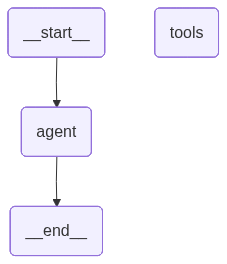

In [ ]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

from dotenv import load_dotenv

load_dotenv()


# 에이전트가 사용할 도구 정의
@tool
def recommand_recipe(dish: str):
    """주어진 요리에 대한 간단한 레시피를 제공합니다."""
    recipes = {
        "파스타": "재료: 스파게티 면, 토마토 소스, 올리브 오일, 마늘. 면을 삶고 소스를 부어주세요.",
        "불고기": "재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.",
        "샐러드": "재료: 양상추, 토마토, 오이, 드레싱. 채소를 썰어 드레싱과 버무려주세요.",
    }
    return recipes.get(dish, "죄송하지만 해당 요리의 레시피를 찾을 수 없습니다.")


# 도구 리스트에 추가
tools = [recommand_recipe]

# ToolNode 생성
tool_node = ToolNode(tools)

# 모델을 GPT로 변경
model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)


# 계속할지 여부를 결정하는 함수 정의
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    # LLM이 도구를 호출하면 "tools" 노드로 라우팅
    if last_message.tool_calls:
        return "tools"
    # 그렇지 않으면 중지(사용자에게 응답)
    return END


# 모델을 호출하는 함수 정의
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    # 기존 목록에 추가되기 때문에 목록을 반환합니다.
    return {"messages": [response]}


# 새로운 그래프 정의
workflow = StateGraph(MessagesState)

# 사이클링할 두 노드 정의
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 진입점을 'agent'로 설정
# 이는 첫 번째로 호출되는 노드를 의미한다
workflow.set_entry_point("agent")

# 조건부 경로 추가
workflow.add_conditional_edges(
    # 먼저, 시작 노드를 정의한다. 'agent'를 사용한다.
    # 이는 'agent' 노드가 호출된 후의 경로를 의미한다.
    "agent",
    # 다음으로 어느 노드가 다음에 호출될지 결정하는 함수를 전달한다.
    should_continue,
   
)

# 'tools'에서 'agent'로의 일반 경로 추가
# 이는 'tools'가 호출된 후 'agent' 노드가 다음에 호출된다는 것을 의미
workflow.add_edge("tools", "agent")

# 그래프 실행 간 상태를 유지하기 위해 메모리 초기화
checkpointer = MemorySaver()

# 마지막으로 컴파일 하는 단계
# 그래프를 컴파일할 때 메모리 옵션을 checkpointer로 전달할 수 있다.
app = workflow.compile(checkpointer=checkpointer)

final_state = app.invoke(
    {"messages": [HumanMessage(content="불고기 레시피를 알려줘")]},
    config={"configurable": {"thread_id": 100}},
)

print(final_state["messages"][-1].content)

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass
